# Семинар 7: Few/Zero Shot Learning


## Вступление
Мы привыкли, что задача машинного обучения предполагает наличие большого количества данных. А что если:

1. Существуют какие-то редкие случаи, примеров которых в обучающей выборке всего несколько штук. Тогда формально мы имеем задачу классификации на $C$ классов, из них $K < C$ классов имеют мало обучающих примеров, и нужно уметь различать между всеми классами, как многочисленными, так и малочисленными.

2. Для какой-то задачи в целом может быть сложно (долго, дорого, ненадежно...) собирать какие-то данные (например, компьютерная томография или МРТ). Здесь же у нас всего $K$ классов, и для каждого из этих классов имеется мало объектов в выборке.

Для таких задач был разработан ряд __Few Shot Learning__ алгоритмов. Если у нас $K$ редких классов, каждый из которых представлен $N$ объектами, то в англоязычной литературе такая Few Shot задача называется __$K$-way $N$-shot__ классификацией/регрессией/детекцией/...

Сегодня мы познакомимся с решениями, которые позволяют получать адекватное качество предсказаний, несмотря на крайне маленькое (или даже совсем отсутствующее!) количество данных.

### План семинара:
0. Подгрузим данные для Few Shot классификации
1. Metric Learning для Few Shot классификации
2. Meta Learning для Few Shot классификации
3. Zero Shot классификация

## 0. Подгрузим данные для Few Shot классификации

In [2]:
!pip install pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 49.8 MB/s eta 0:00:00


In [3]:
import warnings

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn
from torchmetrics.functional import accuracy
from torchvision import transforms

warnings.filterwarnings("ignore")
%matplotlib inline

Для начала соберем себе маленькую выборку. Пускай это будет подвыборка хорошо знакомой нам выборки CIFAR10, в которой 10 классов цветных изображений размера 32х32.

Сделаем класс `CifarSubset`, который будет представлять собой dataset, состоящий из подвыборки __N__ объектов каждого из 10 классов.

In [4]:
class CifarSubset(torchvision.datasets.vision.VisionDataset):
    def __init__(self, root, k_n, train: bool, download: bool, transform):
        super().__init__(root, transform=transform, target_transform=None)

        self.k_n = k_n
        self.data = self.__sample_uniform_subset(root, train, download, transform)

    def __sample_uniform_subset(self, root, train, download, transform):
        """
        Метод вернет такую подвыборку выборки CIFAR10,
        что объектов каждого класса будет ровно k_n штук.

        :param: dataset — исходная выборка
        :param: k_n — количество объектов в каждом классе
        """

        self.cifar_full = torchvision.datasets.CIFAR10(
            root=root, train=train, download=download, transform=transform
        )

        number_of_classes = len(self.cifar_full.classes)
        class_count = [0 for _ in range(number_of_classes)]
        subset = []

        for image, label in self.cifar_full:
            # мы хотим ровно k_n объектов каждого класса
            if class_count[label] < self.k_n:
                subset.append((image, label))
                class_count[label] += 1

            # если каждый класс имеет k_n объектов - выходим из цикла
            if sum(class_count) == number_of_classes * self.k_n:
                break
        return subset

    def __getitem__(self, index):
        return self.data[index][0], self.data[index][1]

    def __len__(self):
        return len(self.data)

In [5]:
N_SHOT = 5  # количество объектов каждого класса в обучающей выборке

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train_subset = CifarSubset(
    root="./cifar", k_n=N_SHOT, train=True, download=True, transform=transform
)

cifar_val_subset = CifarSubset(
    root="./cifar", k_n=N_SHOT, train=False, download=True, transform=transform
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12601527.22it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


Многие алгоритмы для Few Shot (и особенно Meta) Learning лучше тренировать так называемыми __эпизодами__, где эпизодом называют ситуацию, максимально приближенную к условиям инференса. Например, если во время инференса мы будем просить модель классифицировать __N__ объектов каждого из __K__ классов, то и тренировать ее стоит батчами по __N__ * __K__ классов.

И так как в нашем случае __N__ * __K__ — это и есть _все_ наши данные, то у нас один эпизод эквивалентен одной эпохе.

In [6]:
# тк нам нужно обучаться эпизодами, батч должен содержать в себе сразу все данные
train_dataloader = torch.utils.data.DataLoader(
    cifar_train_subset,
    batch_size=N_SHOT * 10,  # 10 потому что в нашей выборке 10 классов
    shuffle=True,
    num_workers=1,
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val_subset, batch_size=N_SHOT * 10, shuffle=True, num_workers=1
)

Если воспользоваться решениями, которые были у нас до сегодняшнего дня, то модель просто не выучит никаких закономерностей малочисленного класса и сильно переобучится.

Специально для таких задач был разработан ряд алгоритмов - несколько из них мы сегодня рассмотрим!

---

## 1. Few Shot Metric learning

Основная цель подходов данного вида - понять как выглядят выученные признаки (или эмбеддинги) типичного представителя каждого класса. Имея такие "прототипы" классов можно будет сравнивать признаки каждого из объектов с признаками каждого прототипа и выбирать тот, который наиболее похож на наш объект. Для того чтобы это работало, нужно убедиться, что во время обучения мы делаем так, что похожие объекты находятся рядом в пространстве признаков, а непохожие — далеко друг от друга (совсем как в задаче кластеризации).

---

Верхнеуровнево это всегда выглядит примерно одинаково:

1. На тех данных, что у нас имеются, обучается какая-то модель, выходом которой будут __не вероятности классов__, а __многомерный вектор признаков__ (можно взять любую из наших предыдущих моделей классификации/регрессии и отбросить последний классификационный слой).

2. Функция потерь подбирается таким образом, чтобы модель училась группировать между собой похожие данные.

3. В случае __K__-way __N__-shot классификации как во время обучения, так и во время инференса, происходит одно и то же. Какой-то процент из __N__ объектов каждого класса выбирается для формирования прототипа класса путем усреднения их признаков. Такая подвыборка будет называться вспомогательным множеством или __support set__. А оставшиеся объекты (которые мы, собственно, будем сравнивать с этим прототипом) называются множеством запросов или __query set__.

---

1. Построим простую свёрточную архитектуру, выходом которой для каждого объекта будет многомерный вектор выученных признаков:

In [7]:
class PrototypeNet(nn.Module):
    def __init__(self, input_dim=3, hid_dim=64, output_dim=64):
        super(PrototypeNet, self).__init__()

        self.encoder = nn.Sequential(
            self.__conv_block(input_dim, hid_dim),
            self.__conv_block(hid_dim, hid_dim),
            self.__conv_block(hid_dim, hid_dim),
            self.__conv_block(hid_dim, output_dim),
        )

    def __conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

2. Теперь нужно выбрать такой функционал потерь, который будет штрафовать за:

  - большие расстояния между объектом и прототипом его класса
  - маленькие расстояния между объектом и прототипом _не_ его класса

  Так как готовых решений в торче нет, придется писать свой Loss... Чтобы не подбирать математику, описывающую нужные нам условия, воспользуемся подходом, представленным в [данной работе](https://arxiv.org/pdf/1703.05175.pdf). Тогда формирование функционала ошибки будет выглядеть следующим образом:

---

- Для каждого класса $c$:
    - Для каждого объекта $q$ из нашего __query_set($с$)__
      
  $$
  Loss +=  {1 \over N_c * N_q} * \left[\text{dist}(\text{emb}(q), p_c) + \log{\sum_{classes} e^{-\text{dist}(\text{emb}(q), p_{class})}} \right],
  $$

  где $\text{emb}(q)$ — эмбеддинг, полученный после того как объект $q$ прошел через нашу свёрточную сеть, а $\text{dist}(\text{emb}(q), p_c)$ — какая-то функция расстояния между этим эмбеддингом и прототипом $p_c$ класса $c$.
---
  С первого взгляда происходит что-то страшное, и непонятно почему взяты именно такие значения. Но если приглядеться, то будет понятно, что первое слагаемое в скобках - это просто расстояние от нашего объекта до прототипа своего класса, а второе слагаемое (в виде суммы) становится тем меньше, чем дальше наш объект от всех остальных прототипов.
  
  Таким образом, минимизируя представленный функционал по параметрам нейросети, мы как раз приближаем наш объект к своему прототипу и отдаляем от всех остальных!

In [8]:
class PrototypeLoss(nn.Module):
    def __init__(self, n_shot: int):
        super(PrototypeLoss, self).__init__()
        self.n_shot = n_shot
        self.__prototypes: list = None

    def __distance(self, inp, other):
        return torch.linalg.norm(inp - other)

    def __prototype_loss(
        self,
        predicted_embeddings: torch.Tensor,
        target_labels: torch.Tensor,
        support_percent: float = 0.6,
    ):
        """
        :param predicted_embeddings: векторы признаков, полученные в результате работы модели; shape = (N, emb_size)
        :param target_labels: список целевых классов; shape=(N)
        :param: support_percent: процент данных каждого класса, который будет использоваться для формирования прототипа класса
        """

        assert 0 < support_percent < 1

        classes = torch.unique(target_labels)
        n_classes = len(classes)  # количество классов за эпизод

        # количество данных для определения прототипа класса
        n_support = int(self.n_shot * support_percent)
        # количество данных для сравнения с прототипом класса
        n_query = self.n_shot - n_support

        prototypes = []  # прототипы класса (количество классов, вектор признаков)
        class_queries = []

        for c in classes:
            supports = predicted_embeddings[target_labels == c][:n_support]
            queries = predicted_embeddings[target_labels == c][n_support:]

            # прототип класса - это усредненное значение всех support объектов
            prototypes.append(supports.mean(0))
            # запросы класса - это все объекты, не попавшие в support
            class_queries.append(queries)

        loss = torch.tensor(0.0)

        for i, queries in enumerate(class_queries):
            for query in queries:  # пробегаемся по всем объектам класса i
                loss += self.__distance(prototypes[i], query)

                distances = torch.stack(
                    [
                        self.__distance(query, p)
                        for ci, p in enumerate(prototypes)
                        if i != ci
                    ]
                )
                # добавим значение, обратное сумме этих расстояний
                # чем больше расстояния, тем меньше мы наказываем модель

                loss += torch.log(torch.sum(torch.exp(-distances)))

        # сохраним прототипы для возможности дальнейших предсказаний
        self.prototypes = torch.stack(prototypes)

        return loss / (n_classes * n_query)

    def forward(self, predicted_embeddings, targets) -> torch.Tensor:
        return self.__prototype_loss(predicted_embeddings, targets)

    def get_class_prototypes(self) -> list:
        return self.__prototypes

Теперь осталось знакомым нам образом собрать все это дело в один LightningModule

In [9]:
class FewShotMetricLearner(pl.LightningModule):
    def __init__(self, n_shot: int) -> None:
        super().__init__()

        self.model = PrototypeNet()
        self.loss = PrototypeLoss(n_shot)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        # это значение заполнится позже, во время расчета ошибки
        self.prototypes = None

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def predict_labels(self, batch_embeddings):
        if self.prototypes == None:
            raise ValueError("self.prototypes was not set")

        ans = []
        for e in batch_embeddings:
            dists = torch.linalg.norm(self.prototypes - e, dim=1)
            ans.append(torch.argmin(dists))

        return torch.stack(ans)

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        embeddings = self.forward(images)

        loss = self.loss(embeddings, target)
        # label_predictions = self.predict_labels(embeddings)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        embeddings = self.forward(images)

        loss = self.loss(embeddings, target)
        self.prototypes = self.loss.prototypes

        label_predictions = self.predict_labels(embeddings)
        acc = accuracy(label_predictions, target, task ='multiclass', num_classes=10)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

In [10]:
few_shot_metric_learner = FewShotMetricLearner(n_shot=N_SHOT)

trainer = pl.Trainer(accelerator="cpu", max_epochs=50)
trainer.fit(few_shot_metric_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | PrototypeNet  | 113 K 
1 | loss  | PrototypeLoss | 0     
----------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.452     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Мы классифицируем объекты с accuracy 0.6-0.7, обучив (__примерно за минуту на cpu__) простейшую свёрточную сеть всего на __5 объектах (!!!)__ каждого класса.

---

## 2. Few Shot Meta Learning
    
Мета обучение ставит перед собой задачу "научиться учиться". В нашем случае, "научиться классифицировать". Это более общая задача, ведь в случае обучения с учителем мы не просто "учимся классифицировать", а "учимся классифицировать на конкретные классы". Давайте подробнее рассмотрим один из Meta Learning алгоритмов.

__Model Agnostic Meta Learning (MAML)__ [ссылка на статью](https://arxiv.org/pdf/1703.03400.pdf)

Целью Few Shot мета обучения является обучение модели, которая может быстро адаптироваться к новой задаче, используя всего несколько объектов и итераций обучения.По сути, проблема __мета обучения__ рассматривает __целые задачи как обучающие примеры__. То есть целая задача классификации на кошек и собак — это один объект обучающей выборки, на машины и самолеты — второй объект обучающей выборки и так далее.

1. При решении эпизода __K__-way __N__-shot классификации мы каждый эпизод показываем __разные K классов__!
2. Во время эпизода мы используем _train_ выборку для того, чтобы обучать классификатор (любую привычную нам архитектуру, именно отсюда Model Agnostic в названии) так, как мы делали в обычной задаче классификации.
3. После эпизода мы используем ошибку и лосс на _val_ выборке (где у нас уже другое множество задач классификации) для того, чтобы провести мета обучение.
4. В конце обучения используется _test_ выборка, состоящая из нескольких _(не показанных ни в val, ни в test)_ задач классификации, на которой и измеряется качество работы модели.

![a](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/few-shot-classification.png)

За счет этого и получается обобщение. Модель учится не просто отличать данные __K__ классов, а в целом - отличать между собой __любые K классов__ по __N__ примерам. А процесс мета обучения находит и адаптирует наиболее задаче-чувствительные параметры модели. Стоит отметить, что это всего лишь один представитель огромного множества Meta Learning алгоритмов.

P.S. Существует библиотека [pytorch-meta](https://github.com/tristandeleu/pytorch-meta) (это не официальная реализация от команды pytorch, но полезный функционал найти можно), в которой есть реализации известных Meta Learning алгоритмов, в том числе - [имплементация алгоритма MAML](https://github.com/tristandeleu/pytorch-meta/tree/master/examples/maml), который мы разобрали выше.

---

## 3. Zero Shot Learning

### Основная идея:

В задаче __Zero-Shot__ classification/detection/segmentation мы хотим предсказывать классы/коробки/маски объектов, которые ни разу не встречали во время обучения. Например, мы все обучение проводили на кошках и собаках, а модель умеет классифицировать еще и львов. Zero-shot модели обучаются на одних данных, а тестируются на тех, которые во время обучения не были показаны.

**Зачем нужен zero-shot?**
Может быть такое, что разметка — непростительно долгая и дорогая операция. Конструкция моделей Zero-shot позволяет использовать знания из одной области (например из текстов), чтобы иметь возможность предсказывать невиданные во время обучения классы по изображению.

С zero-shot моделями будем знакомиться на примере очень известной архитектуры CLIP (Contrastive Language–Image Pre-training). Далее в семинаре — краткий пересказ [статьи](https://openai.com/blog/clip/) из блога компании, создавшей архитектуру.

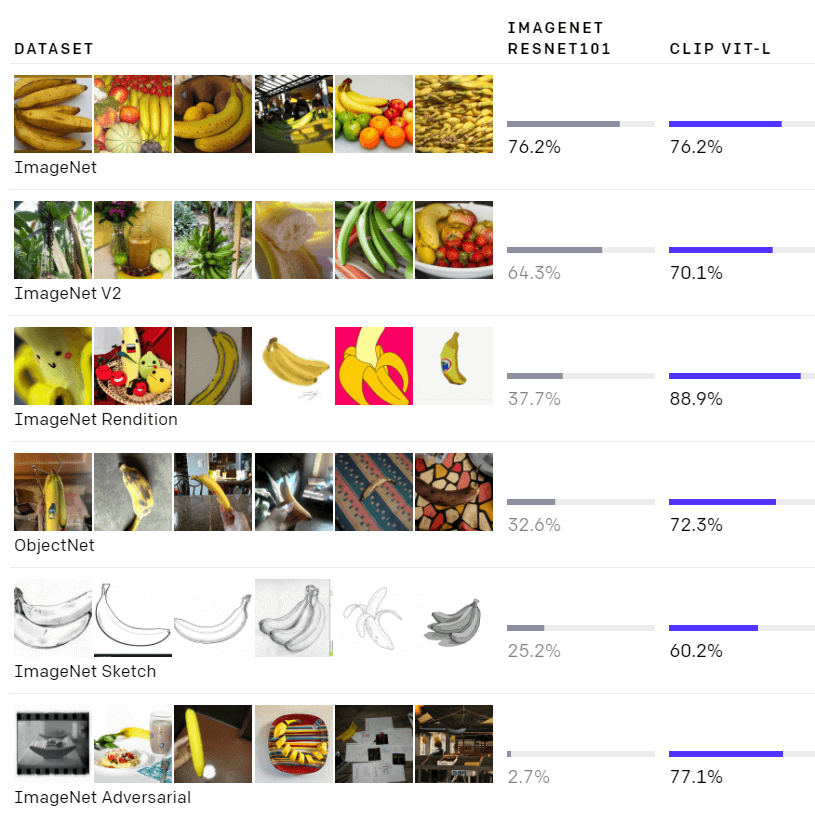

Данные состоят из картинок из интернета с подписями к ним. То есть один объект тренировочной выборки — это пара (изображение, текстовое описание). Например, фотография собаки и подпись "Это моя собака". А процесс обучения строится из таких шагов:

__1. Contrastive pre-training__

- Существуют две модели: одна — для извлечения признаков из изображения, вторая — для извлечения признаков из текста. Можете представлять себе любую свёрточную архитектуру без последнего слоя. На изображении ниже — Image Encoder и Text Encoder соответственно.

- Далее обучаем такой лосс, чтобы расстояние между извлеченными признаками изображения и извлеченными признаками текста были маленькими для соответствующей пары (изображение, текстовое описание) и большими для всех остальных.

  То есть вектор признаков, извлеченный из изображения собаки, должен быть похож на вектор признаков, извлеченный из текста "Это моя собака", и очень не похож на вектор признаков от подписи к другой фотографии.

- Таким образом, модель учится определять, насколько какое-то изображение релевантно к тексту и наоборот.

__(2) and (3).  Create dataset classifier from label text__

Когда во время тестирования нужно классифицировать новое изображение, мы сравниваем признаки, извлеченные из этого изображения, с признаками, извлеченными из __N__ текстов, специально заготовленных нами заранее. __N__ — общее количество классов, в которое входят как классы, которые были во время обучения, так и классы, которых не было. Специальная заготовка текстов заключается в том, что эти тексты формируются по какой-то заготовке формата "Это фотография {класс}", и дальше для каждого из __N__ классов просто вставляется название класса. Из-за того что модель умеет сравнивать признаки, извлеченные с подписей к фотографиям, и признаки, извлеченные с самих фотографий, во время тестирования мы можем просто сравнить близость признаков изображения с признаками всех искусственно созданных текстов и классифицировать изображение, выбрав самую подходящую по мнению модели подпись.


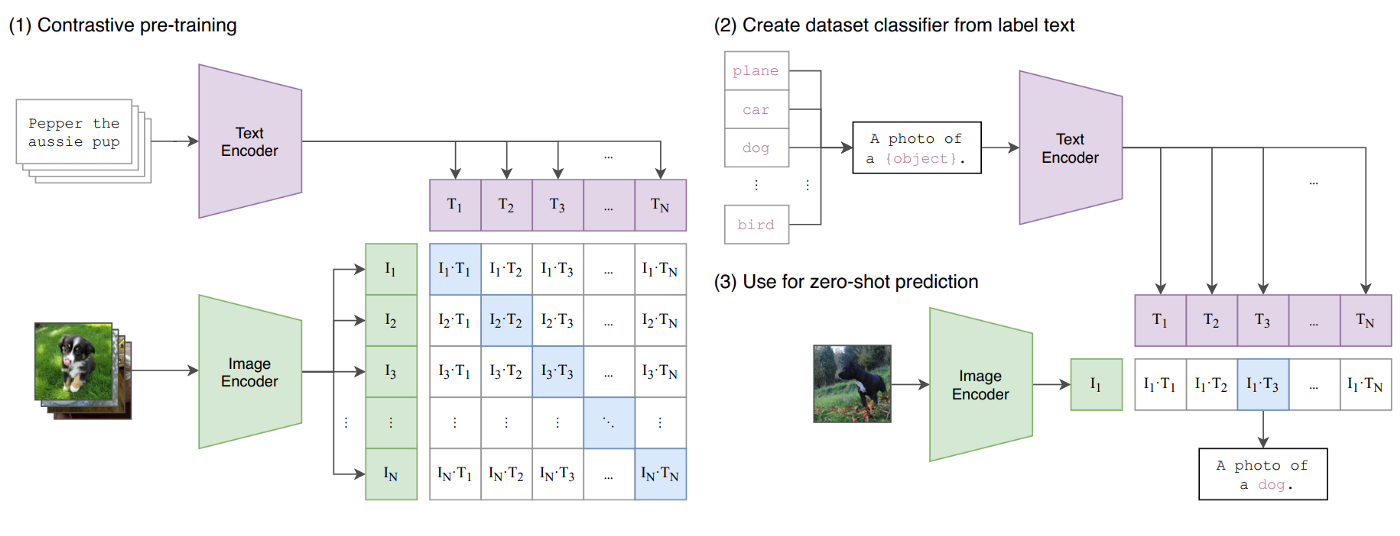

### Ограничения:
1. Плохо считает количество объектов, а также путается на цифрах, например, на MNIST
2. Если уходить в глубину класса (порода собаки или марка машины), то ошибка сильно возрастает

### Теперь посмотрим, что можно поделать с этой моделью в коде

In [11]:
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00


In [12]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 2.1.0+cu118


Для извлечения признаков из изображения, в статье указано несколько архитектур, на которых проводились эксперименты с моделью. Вот они слева направо (ViT - это Visual Transformer, они будут чуть позже (или сильно позже)):

In [13]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Мы выберем хорошо знакомый нам ResNet50.

In [15]:
# если упадет из-за несоответствия checksum - попробуйте запустить ячейку заново
model, preprocess = clip.load("RN50x64")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|█████████████████████████████████████| 1.26G/1.26G [00:28<00:00, 46.7MiB/s]


Model parameters: 623,258,305
Input resolution: 448
Context length: 77
Vocab size: 49408


Вспоминаем из предыдущего модуля, что прежде чем работать с текстом, его надо токенизировать.

In [16]:
clip.tokenize("Hello World!")  # "Hello World!" -> "<BOS>Hello World!<EOS>"

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [17]:
# Пространство эмбеддингов длины 77
clip.tokenize("Hello World!").size()

torch.Size([1, 77])

Посмотрим, насколько хорошо модель понимает разные по написанию, но схожие по сути предложения.

In [18]:
tensor1 = clip.tokenize("google cloud platform").to(torch.float32)
tensor2 = clip.tokenize("amazon web services").to(torch.float32)

In [19]:
cos = torch.nn.CosineSimilarity(dim=1)
output = cos(tensor1, tensor2)
print(output)

# Как видим, весьма неплохо понимает схожие объекты

tensor([0.9993])


### Возьмем базовый пример из гайда

In [20]:
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# название файла и описание к изображению в этом файле
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
}

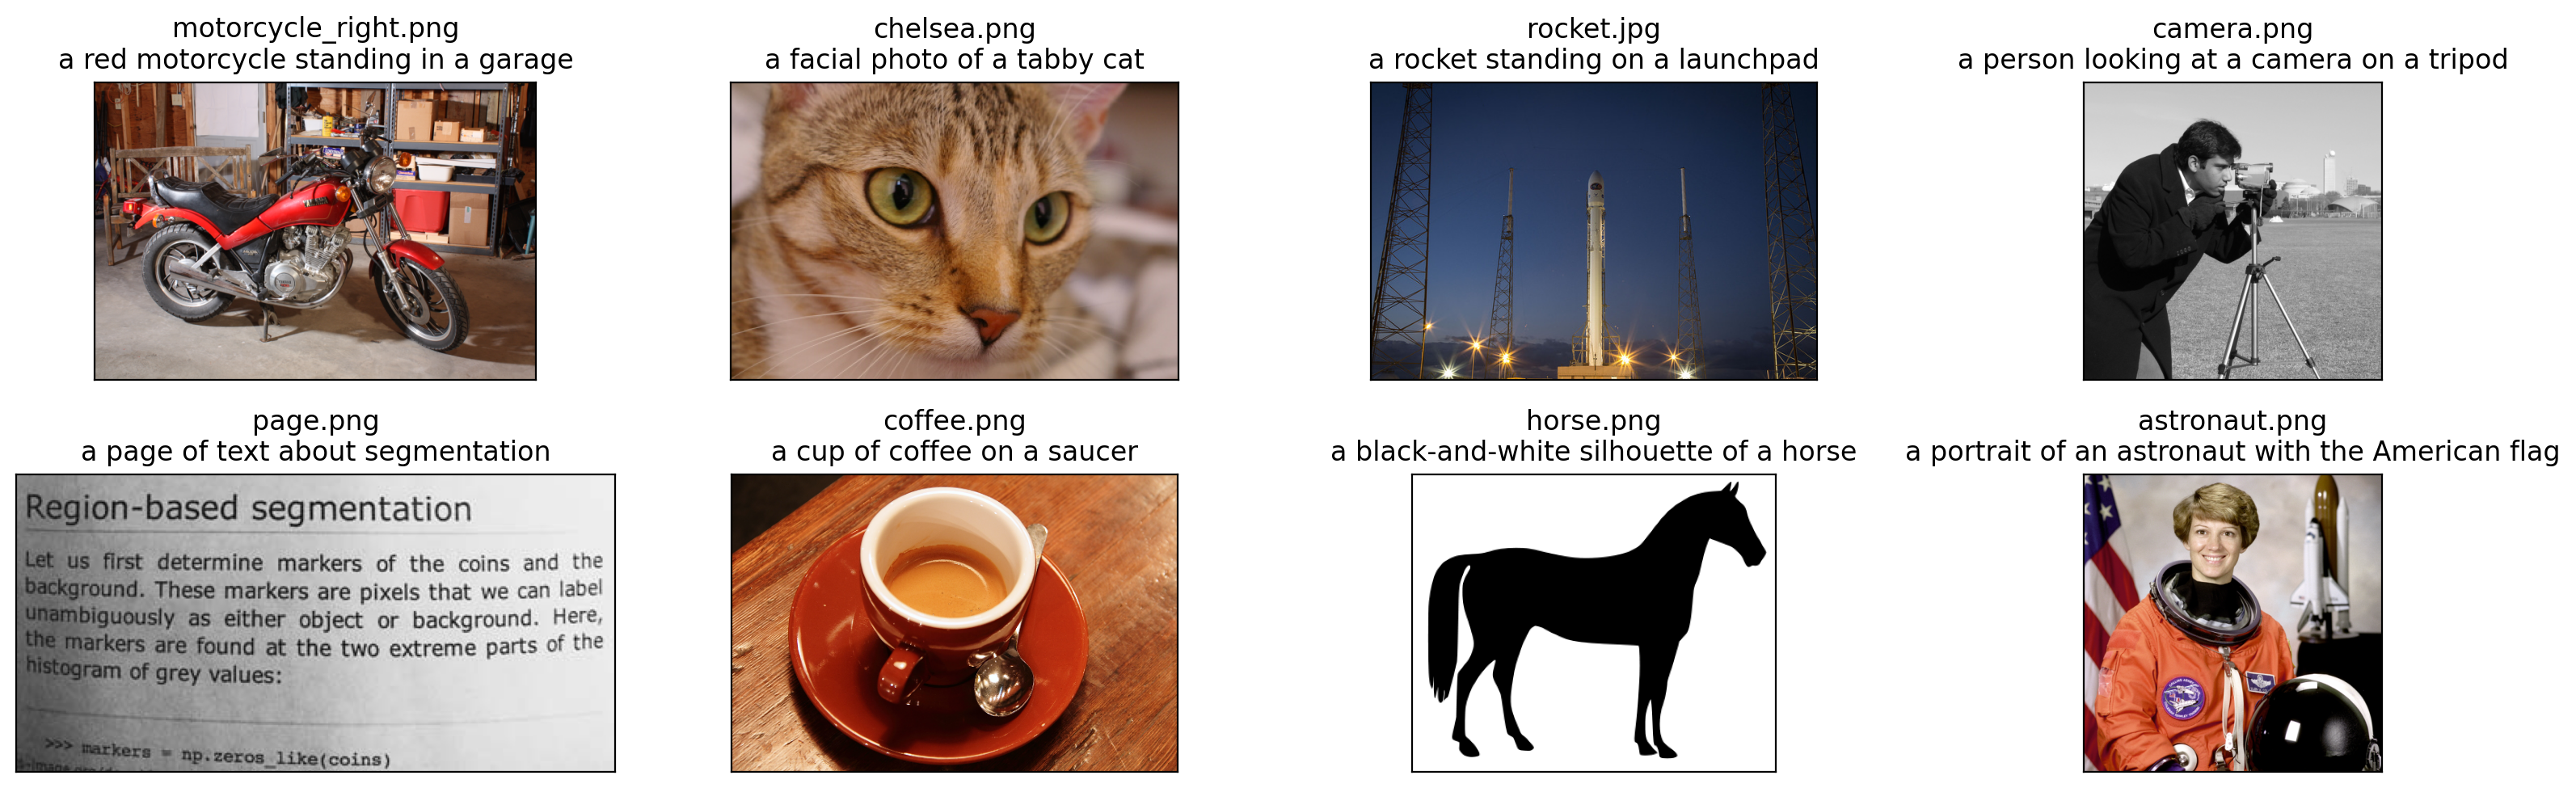

In [21]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [
    filename
    for filename in os.listdir(skimage.data_dir)
    if filename.endswith(".png") or filename.endswith(".jpg")
]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

### Pre-processing



In [22]:
image_input = torch.tensor(np.stack(images)).cuda()

# Добавляем this is — модель лучше работает, когда мы достаточно конкретно указываем ей, что хотим получить
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [23]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Косинусное растояние

In [24]:
image_features /= image_features.norm(
    dim=-1, keepdim=True
)  # нормализуем для операции сравнения
text_features /= text_features.norm(
    dim=-1, keepdim=True
)  # нормализуем для операции сравнения
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

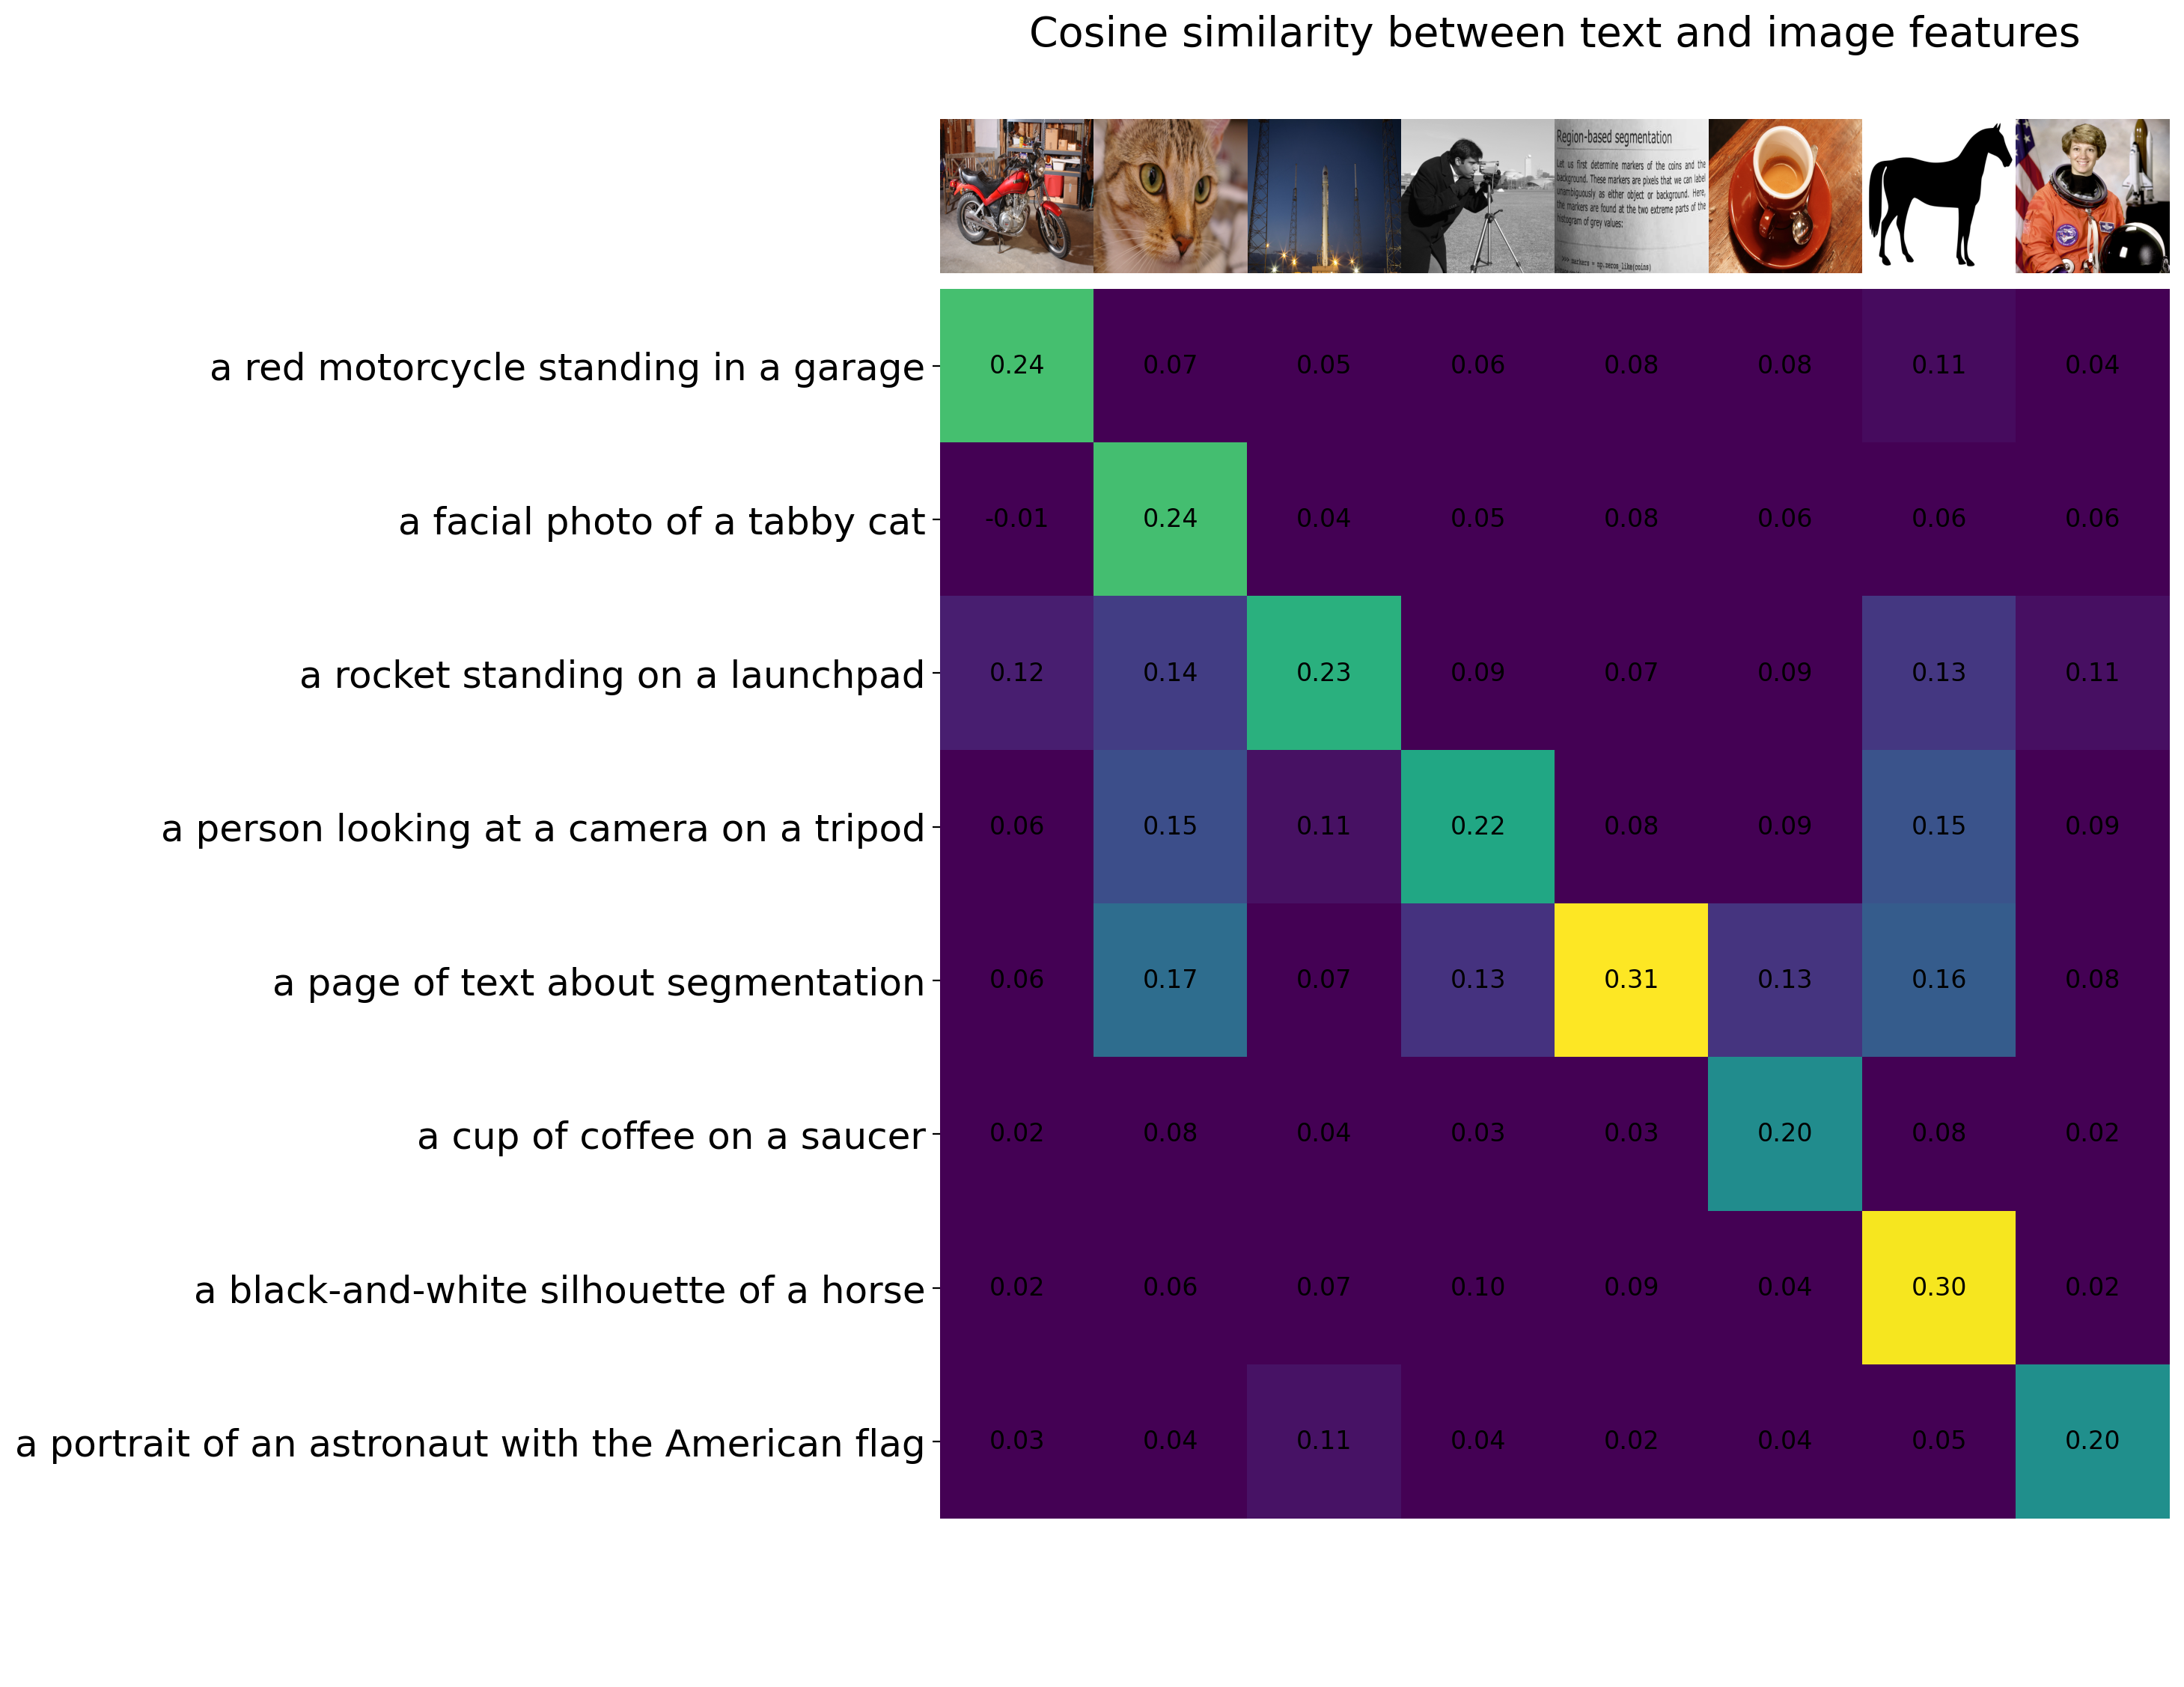

In [25]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

### Zero-shot классификация

In [26]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:18<00:00, 9286754.18it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


Теперь для каждого из классов CIFAR100 создадим искусственные подписи по шаблону "This is a photo of a {название класса}". Таким образом, мы получим 100 подписей, с которыми в дальнейшем будем сравнивать входящее изображение.

In [27]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [28]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

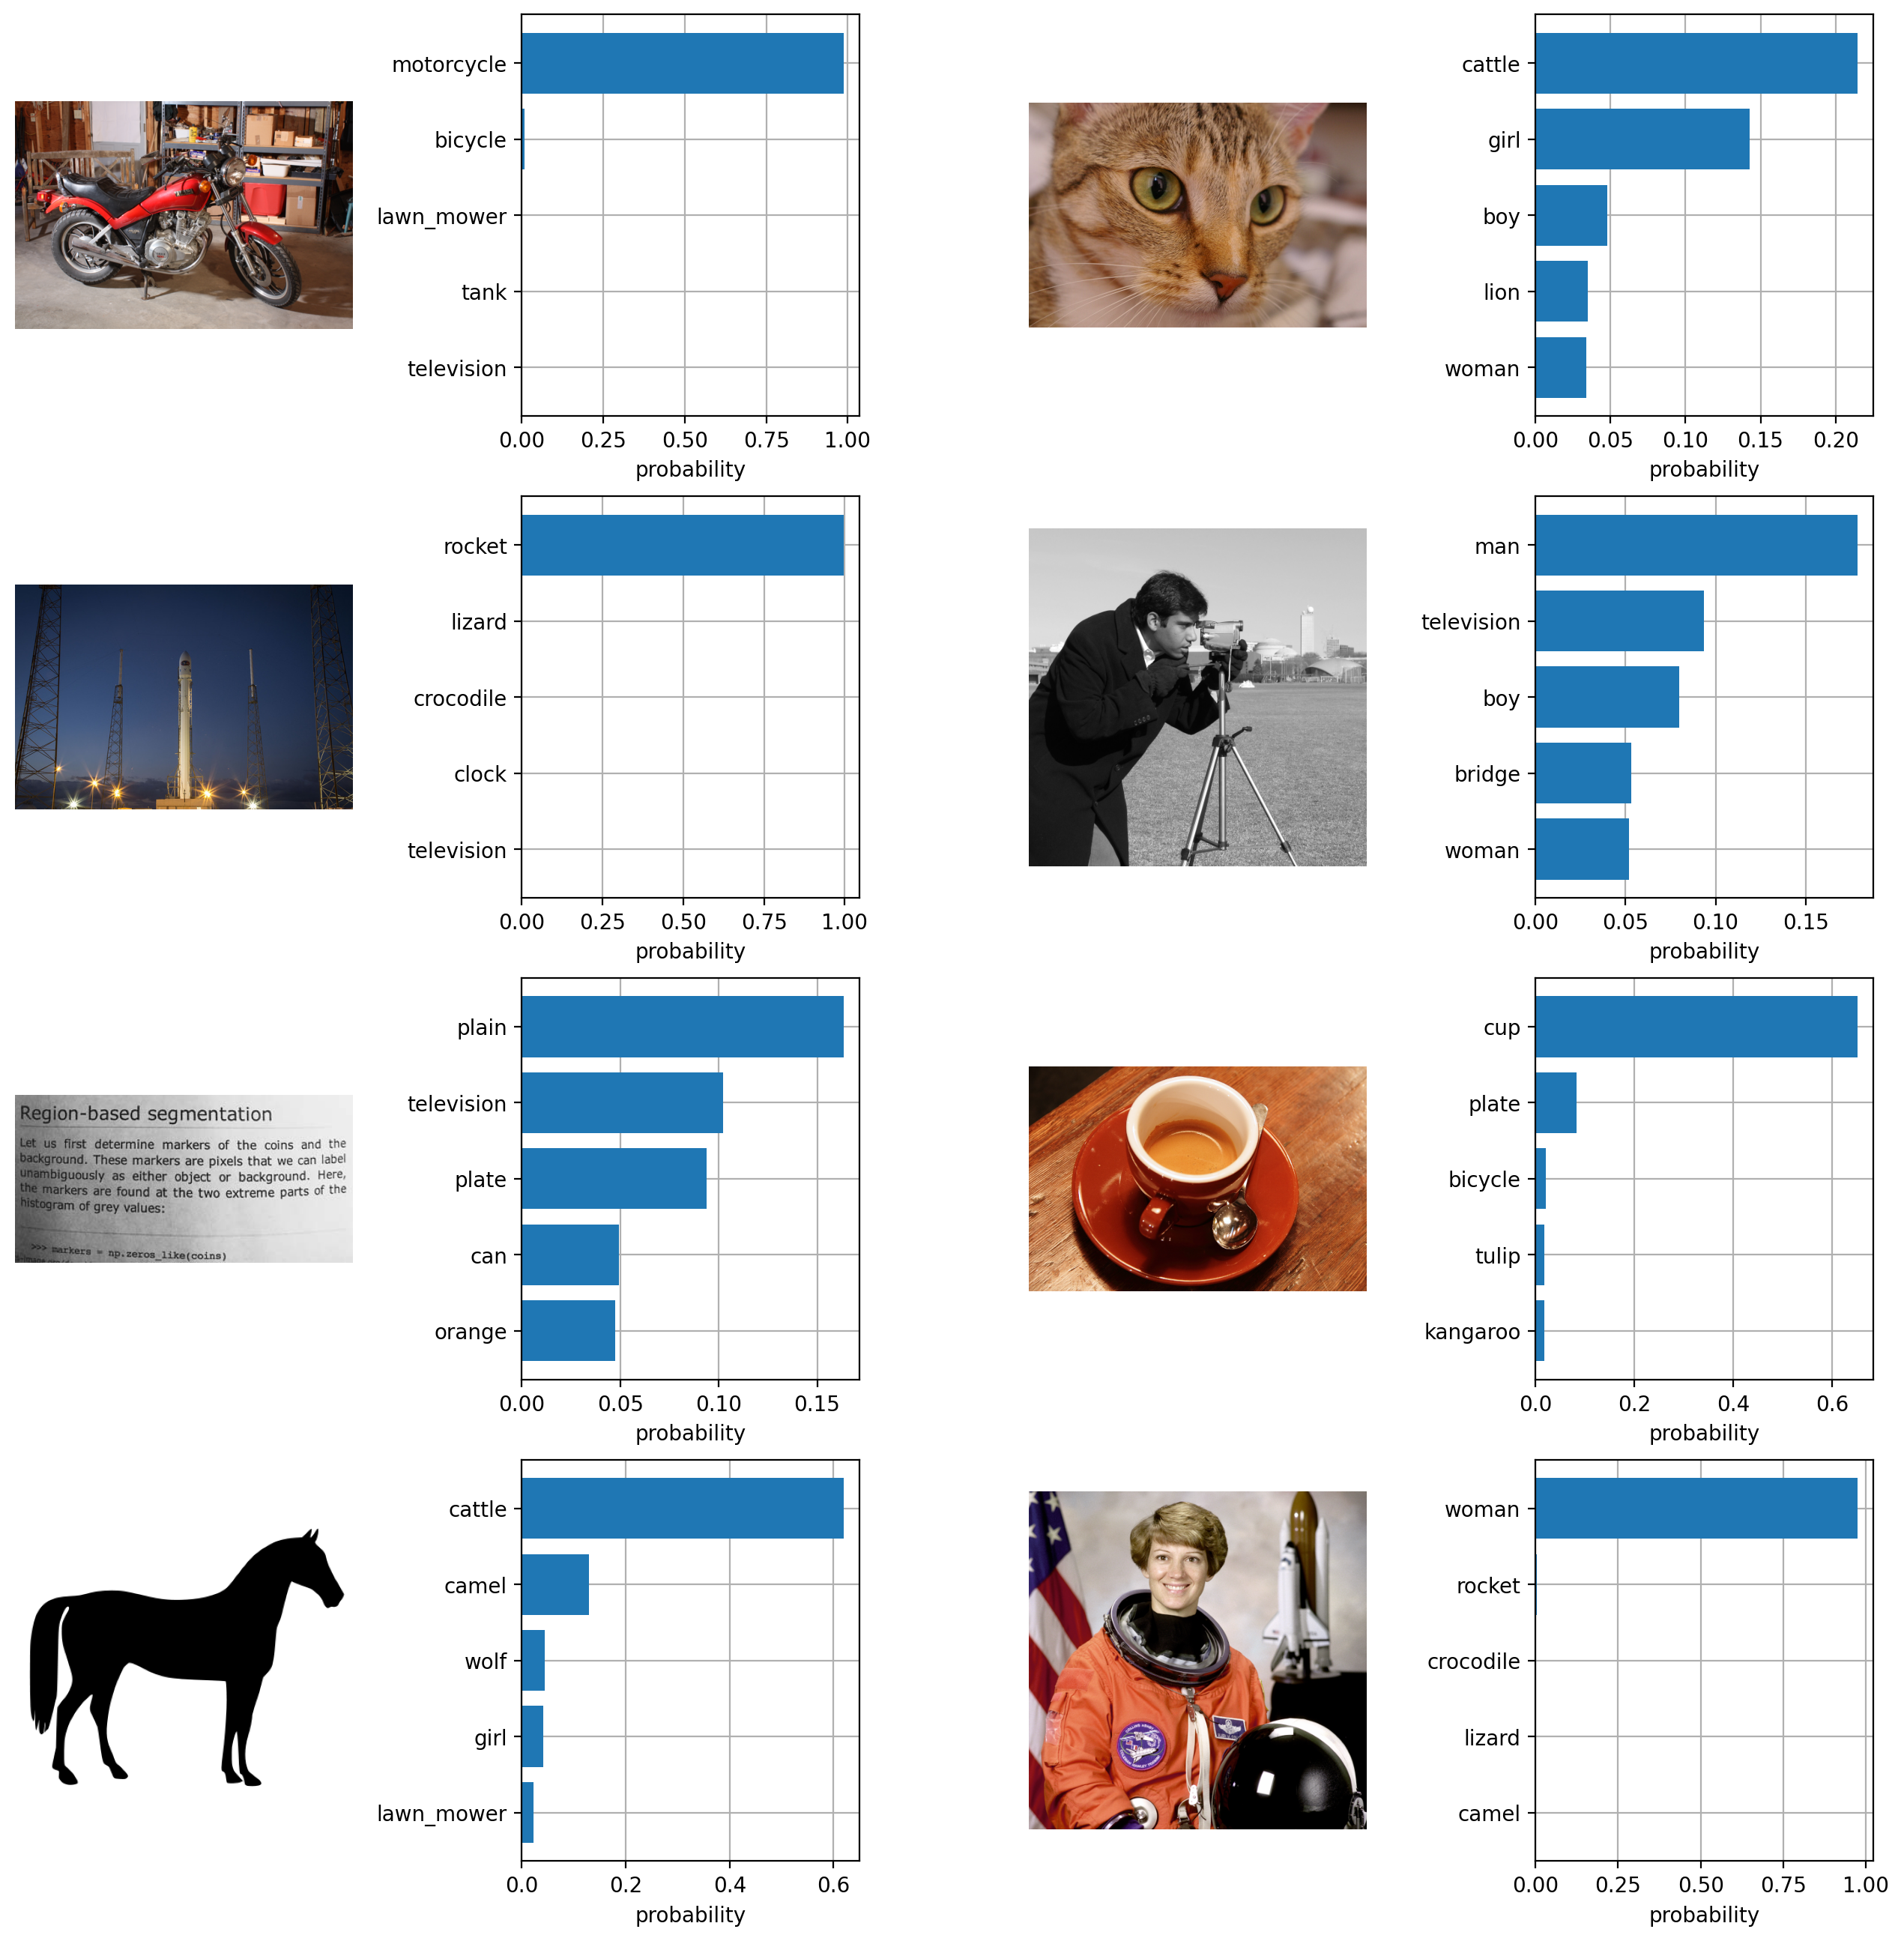

In [29]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()